# 1. Imports

In [1]:
import sys
from pathlib import Path

# Add project root (parent of "electricity") to sys.path

sys.path.append("..")   # go up one level to project root


from electricity.load import Loading
from electricity.preprocessing import Preprocessor



In [2]:
loader = Loading(filepath="complete_dataset.csv", return_X_y=True)

In [3]:
# 3. Load the dataframe
X,y = loader.load_data()

In [4]:
X

,school_day,holiday,RRP_t_minus_1,demand_t_minus_1,min_temperature_t_minus_1,max_temperature_t_minus_1,solar_exposure_t_minus_1,rainfall_t_minus_1
date,,,,,,,,
2015-01-02,0,0,25.633696,99635.030,13.3,26.9,23.6,0.0
2015-01-03,0,0,33.138988,129606.010,15.4,38.8,26.8,0.0
2015-01-04,0,0,34.564855,142300.540,20.0,38.2,26.5,0.0
2015-01-05,0,0,25.005560,104330.715,16.3,21.4,25.2,4.2
2015-01-06,0,0,26.724176,118132.200,15.0,22.0,30.7,0.0
...,...,...,...,...,...,...,...,...
2020-10-02,0,0,34.654671,106641.790,9.4,19.5,21.2,1.8
2020-10-03,0,0,-6.076028,99585.835,12.8,26.0,22.0,0.0
2020-10-04,0,0,-1.983471,92277.025,17.4,29.4,19.8,0.0


In [5]:
# --- Notebook Cell 3: Simple model with unified preprocessing (LinearRegression + TS CV) ---

# Build preprocessing + model pipeline.
# Preprocessor will add date/cyclical features, impute/scale/one-hot, and prune highly correlated features.
pre = Preprocessor(
    filepath="",                 # not used when we pass data directly
    add_date_features=True,      # safe: loader didn't create date features
    corr_threshold=0.95
)


In [6]:
import pandas as pd

In [7]:
pre.set_data(pd.concat([X, y.rename(pre.target_col)], axis=1))

Preprocessor(filepath='', date_col='date', target_col='RRP', leaky_cols=('RRP_positive', 'RRP_negative', 'demand_pos_RRP', 'demand_neg_RRP', 'frac_at_neg_RRP'), bool_maps={'holiday': {'Y': 1, 'N': 0}, 'school_day': {'Y': 1, 'N': 0}}, corr_threshold=0.95, add_date_features=True, random_state=42, df=            school_day  holiday  RRP_t_minus_1  demand_t_minus_1  \
date                                                               
2015-01-02           0        0      25.633696         99635.030   
2015-01-03           0        0      33.138988        129606.010   
2015-01-04           0        0      34.564855        142300.540   
2015-01-05           0        0      25.005560        104330.715   
2015-01-06           0        0      26.724176        118132.200   
...                ...      ...            ...               ...   
2020-10-02           0        0      34.654671        106641.790   
2020-10-03           0        0      -6.076028         99585.835   
2020-10-04           

In [8]:
pipeline = pre.build_pipeline()

In [9]:
pipeline

,steps,"[('date_features', ...), ('pre', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,date_col,'date'
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [10]:
from electricity.models import _tscv_scores
from sklearn.ensemble import RandomForestRegressor


2025-08-26 15:31:50.404726: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-26 15:31:50.405055: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 15:31:50.442283: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-26 15:31:52.171171: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [11]:
#_tscv_scores(pipeline, X, y, model=RandomForestRegressor())

In [12]:
X.shape

(2105, 8)

In [13]:
y.shape

(2105,)

In [14]:
pipeline.fit(X)
X = pipeline.transform(X)

🔎 CorrelationSelector dropped 6 features: [10, 12, 15, 16, 17, 18]


In [15]:
from sklearn.model_selection import TimeSeriesSplit

In [16]:
X.shape

(2105, 13)

In [17]:
train_size = 0.6
index = round(train_size*X.shape[0])

X_train = X.iloc[:index]
X_test = X.iloc[index:]
y_train = y.iloc[:index]
y_test = y.iloc[index:]


In [18]:
# tscv = TimeSeriesSplit(n_splits=5)
# splits = list(tscv.split(X, y))
# X_train, X_test = X.iloc[splits[0][0]], X.iloc[splits[0][1]]
# y_train, y_test = y.iloc[splits[0][0]], y.iloc[splits[0][1]]
X_train.shape, X_test.shape, y_train.shape, y_test.shape




((1263, 13), (842, 13), (1263,), (842,))

In [19]:
X_train.shape[-1]

13

In [20]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers


In [21]:
from tensorflow.keras.callbacks import EarlyStopping


In [22]:
es = EarlyStopping(patience=10, restore_best_weights=True)
model = Sequential()
model.add(layers.Dense(28, input_shape=(X_train.shape[-1],), activation="relu"))
model.add(layers.Dense(21, activation="relu"))
model.add(layers.Dense(14, activation="relu"))
model.add(layers.Dense(7, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.fit(X_train, y_train, epochs=1000, callbacks=[es], validation_split=0.2, batch_size=32, verbose=1)


Epoch 1/1000


/home/kieren/.pyenv/versions/electricity/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-26 15:31:53.066539: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4816.3740 - mae: 57.6368 - val_loss: 16691.4766 - val_mae: 94.0964
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4764.7656 - mae: 57.2213 - val_loss: 16517.2832 - val_mae: 93.1926
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4556.2900 - mae: 55.3815 - val_loss: 15784.0205 - val_mae: 89.4616
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3835.0129 - mae: 48.2277 - val_loss: 13483.3457 - val_mae: 77.0087
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2538.4199 - mae: 35.1272 - val_loss: 10580.3779 - val_mae: 58.6851
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1772.0391 - mae: 29.0412 - val_loss: 9249.9326 - val_mae: 50.8188
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1374.9619 - mae: 25.8295 - val_loss: 8750.7891 - val_mae: 46.7873
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1191.3042 - mae: 23.9170 - val_loss: 8441.5088 - val_mae: 43.5392


In [23]:
model.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36232.1172 - mae: 46.2260


[36232.1171875, 46.22596740722656]

In [24]:
import matplotlib.pyplot as plt

In [25]:
y_test

date
2018-06-18    112.501498
2018-06-19    110.056190
2018-06-20     91.289342
2018-06-21    141.556978
2018-06-22    131.562133
                 ...    
2020-10-02     -6.076028
2020-10-03     -1.983471
2020-10-04     25.008614
2020-10-05     36.764701
2020-10-06     75.771059
Name: RRP, Length: 842, dtype: float64

In [26]:
X_test

,0,1,2,3,4,5,6,7,8,9,11,13,14
1263,0.0,0.0,-0.075590,0.059175,-0.540984,-0.722892,-0.612,19.50,0.333333,0.000000,-0.75,0.0,-0.732051
1264,0.0,0.0,0.815422,0.924708,-0.295082,-0.855422,-0.548,9.00,0.333333,0.000000,-0.50,0.0,-0.732051
1265,0.0,0.0,0.772045,1.183950,-1.360656,-0.554217,-0.300,0.50,0.333333,0.000000,-0.25,0.0,-0.732051
1266,0.0,0.0,0.439139,1.060745,-1.147541,-0.457831,-0.380,0.25,0.333333,0.000000,0.00,0.0,-0.732051
1267,0.0,0.0,1.330840,1.169888,-1.196721,-0.481928,-0.292,0.00,0.333333,0.000000,0.25,0.0,-0.732051
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100,-1.0,0.0,-0.565508,-0.631167,-0.311475,0.048193,0.676,2.25,1.000000,0.666667,0.25,-0.5,0.366025
2101,-1.0,0.0,-1.288032,-0.975560,0.245902,0.831325,0.740,0.00,1.000000,0.666667,0.50,-0.5,0.366025
2102,-1.0,0.0,-1.215434,-1.332294,1.000000,1.240964,0.564,0.00,1.000000,0.666667,0.75,-0.5,0.366025
2103,-1.0,0.0,-0.736620,-1.244217,0.360656,1.253012,-0.348,0.00,1.000000,0.666667,-0.75,-0.5,0.366025


In [27]:
y_pred = model.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [28]:
y_pred

array([[ 113.32978 ],
       [ 127.71665 ],
       [ 122.81644 ],
       [ 110.95008 ],
       [ 132.05882 ],
       [ 125.7149  ],
       [ 112.59814 ],
       [ 129.5059  ],
       [ 134.29211 ],
       [ 119.51655 ],
       [ 118.06863 ],
       [ 125.053566],
       [ 102.77903 ],
       [  90.59949 ],
       [ 116.784676],
       [ 113.67274 ],
       [  93.974266],
       [  86.11407 ],
       [  79.089966],
       [  78.484276],
       [  70.586784],
       [  96.636406],
       [ 115.42351 ],
       [ 120.069725],
       [ 108.78652 ],
       [ 121.09454 ],
       [ 111.514244],
       [  97.07616 ],
       [ 107.562546],
       [ 114.88279 ],
       [  97.54215 ],
       [  94.21616 ],
       [  96.26587 ],
       [ 106.50703 ],
       [ 100.8942  ],
       [ 111.07624 ],
       [ 107.968636],
       [  99.16691 ],
       [  98.83058 ],
       [  99.75325 ],
       [  85.332214],
       [  75.06703 ],
       [  76.90269 ],
       [  95.12388 ],
       [  83.702736],
       [  

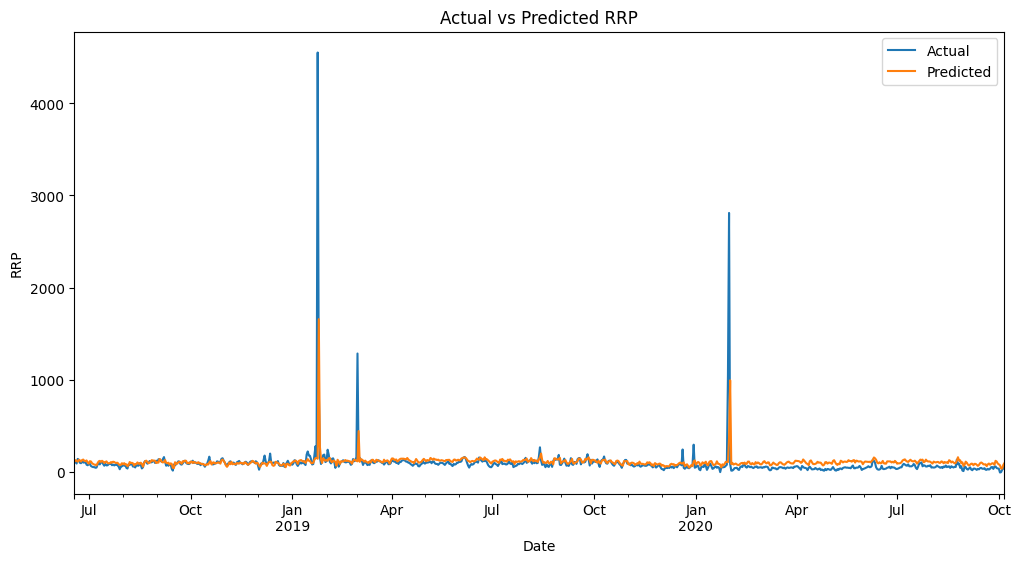

In [29]:
import pandas as pd

# Assume y_test is a pandas Series with date index, X_test is a DataFrame with date index
# If y_test is not a Series with index, adjust accordingly

# Convert y_pred to Series with same index as y_test
y_pred_series = pd.Series(y_pred.flatten(), index=y_test.index, name="Predicted")
y_test_series = pd.Series(y_test, index=y_test.index, name="Actual")

# Combine into a DataFrame
df_pred = pd.DataFrame({"Actual": y_test_series, "Predicted": y_pred_series})

# Plot both against date
df_pred.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("RRP")
plt.title("Actual vs Predicted RRP")
plt.show()


In [30]:
from sklearn.metrics import r2_score

print(f"R2: {r2_score(y_test, y_pred)}")


R2: 0.033061867627804054
